In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotting_functions import colour_dict
from network_functions import *
from upsetplot import plot as upplot
from upsetplot import from_contents
from upsetplot import UpSet
from plotting_functions import *

In [2]:
from adjustText import adjust_text

In [3]:
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/')

In [4]:
save_fig=False

In [5]:
plt.rcParams.update({'font.size': 8})

# functions

In [6]:
def remove_subscript (string,type): 
    for s in ['_FDR','_top500','_bonf']:
        if s in string:
            if type=='trait':
                string = string.replace(s, '')
            if type=='cutoff':
                string=s[1:len(string)]
    if ((type=='cutoff') & (string=='')):
        string='other'
    return string

# Interactome Set-up

pcnet2- versions 
from wright et al. 2024 preprint:
PCNet 2.0= best-performing ranked composite (top 15 interactomes, 3.85M interactions)
PCNet 2.1= top 8 interactomes, 1.75M interactions
PCNet 2.2= top 10 co-citation-free interactomes, 3.32M interactions 

In [7]:
tissue_network=False

In [8]:
interactome_name='PCNet2.0'

In [9]:
if tissue_network==False:
    if (interactome_name=='PCNet2.0'):
        all_nodes=list(pd.read_csv('PCNET2.0_allNodes.tsv',header=None)[0])
    else:
        interactome=import_interactome(UUIDs=UUIDs,interactome_name=interactome_name)
        all_nodes=list(interactome.nodes())

else:
    netdir='tissue_networks/intermediate/'
    tissue='global'
    interactome_name=f'hb_tissue_{tissue}_top'
    #import node list
    with open(f'{netdir}node_list_{tissue}_top.txt', 'r') as file:
        lines = file.readlines()
    # Remove newline characters from each line
    all_nodes=[line.strip() for line in lines]

# import seed genes

In [10]:
if not tissue_network:
    seed_dict=import_seed_dict(mag_dir,file_dict,ctrl_traits,ctrl_traits_rat,psych_traits,bonf_dict,gene_col_dict,all_nodes)
else:
    hgnc=pd.read_csv('hgnc_complete_set.txt',sep='\t',low_memory=False)
    hgnc=hgnc[['symbol','entrez_id']].dropna()
    hgnc['entrez_id']=hgnc['entrez_id'].astype(int).astype(str)
    seed_dict=import_seed_dict(mag_dir,file_dict,bonf_dict,gene_col_dict,hgnc[hgnc.entrez_id.isin(all_nodes)]['symbol']) 
#seed_dict.keys()

In [11]:
seed_n={}
for k in seed_dict.keys():
    seed_n[k]=len(list(seed_dict[k]))
seed_count=pd.DataFrame.from_dict(seed_n,orient='index')
seed_count.columns=['n_seed']

In [12]:
NPS_dict,NPS_dict_series=import_NPS_scores(seed_dict,interactome_name)

# import all datasets as a table

In [13]:
files=os.listdir('colocalization_scores')
files.remove('.ipynb_checkpoints')

In [14]:
files=[x for x in files if interactome_name in x]
files=[x for x in files if ~('munged' in x)]

In [15]:
len(files)

609

In [16]:
tbl=pd.DataFrame()
for f in files:
    print(f)
    t=pd.read_csv(f'colocalization_scores/{f}',sep='\t')
    tbl=pd.concat([tbl,t],axis=0,ignore_index=True)
    print(len(tbl))

colocScore_loco_final_cf_bonf_infant_bw_bonf_PCNet2.0.tsv
60
colocScore_loco_final_cf_bonf_body_length_rn6_bonf_PCNet2.0.tsv
120
colocScore_body_length_rn6_bonf_ext_FDR_PCNet2.0.tsv
180
colocScore_loco_final_cf_25_bonf_ext_fus_naac_top500_PCNet2.0.tsv
240
colocScore_loco_final_cf_25_bonf_maternal_smok_bonf_PCNet2.0.tsv
300
colocScore_loco_final_cf_FDR_facial_hair_top500_PCNet2.0.tsv
360
colocScore_bmi_rn6_bonf_addict-rf_FDR_PCNet2.0.tsv
420
colocScore_loco_final_cf_bonf_dpw_bonf_PCNet2.0.tsv
480
colocScore_loco_final_mega_top500_friend_sat_FDR_PCNet2.0.tsv
540
colocScore_loco_final_cf_25_bonf_antisoc_bonf_PCNet2.0.tsv
600
colocScore_loco_final_cf_bonf_asd_FDR_PCNet2.0.tsv
660
colocScore_loco_gsem_FDR_addict-rf_FDR_PCNet2.0.tsv
720
colocScore_loco_final_cf_FDR_nsex_bonf_PCNet2.0.tsv
780
colocScore_loco_final_cf_FDR_ocd_FDR_PCNet2.0.tsv
840
colocScore_loco_final_cf_FDR_park_top500_PCNet2.0.tsv
900
colocScore_loco_FDR_LDL_top500_PCNet2.0.tsv
960
colocScore_loco_gsem_FDR_age_menarche_FDR_P

In [17]:
tbl['rat_trait']=tbl['rat_dataset'].apply(remove_subscript,type='trait')
tbl['rat_cutoff']=tbl['rat_dataset'].apply(remove_subscript,type='cutoff')
tbl['human_trait']=tbl['human_dataset'].apply(remove_subscript,type='trait')
tbl['human_cutoff']=tbl['human_dataset'].apply(remove_subscript,type='cutoff')

In [18]:
tbl=tbl[(~tbl['rat_dataset'].str.contains('fus'))& (~tbl['human_dataset'].str.contains('fus'))]
tbl=tbl[(~tbl['rat_dataset'].str.contains('rat'))& (~tbl['human_dataset'].str.contains('rat'))]
tbl=tbl[(~tbl['human_dataset'].str.contains('loco'))]

In [19]:
tbl=tbl.dropna(axis=0)

In [20]:
tbl['lower_error'] = tbl.apply(lambda x: x['obs_exp'] - x['observed_overlap']/(x['expected_overlap_mean']+ 1.96*x['expected_overlap_std']), axis = 1)
tbl['upper_error'] = tbl.apply(lambda x: x['observed_overlap']/(x['expected_overlap_mean'] - 1.96*x['expected_overlap_std']) - x['obs_exp'], axis = 1)

In [21]:
tbl=tbl.merge(seed_count, left_on='human_dataset',right_on=seed_count.index)

In [22]:
tback=tbl
#tbl=tback

In [23]:
tbl[(tbl.human_dataset=='ext_top500') & (tbl.rat_dataset=='loco_final_cf_FDR')]

,z_comb,z_12,observed_overlap,expected_overlap_mean,expected_overlap_std,empirical_p,obs_exp,rat_dataset,human_dataset,rat_trait,rat_cutoff,human_trait,human_cutoff,lower_error,upper_error,n_seed
6961,1,1.0,744,623.08,19.707704,4.240009e-10,1.194068,loco_final_cf_FDR,ext_top500,loco_final_cf,FDR,ext,top500,0.069704,0.078917,500
6962,1,1.5,289,221.65,14.192516,1.040171e-06,1.303857,loco_final_cf_FDR,ext_top500,loco_final_cf,FDR,ext,top500,0.145389,0.187119,500
6963,1,2.0,86,82.96,7.452409,3.416655e-01,1.036644,loco_final_cf_FDR,ext_top500,loco_final_cf,FDR,ext,top500,0.155196,0.221525,500
6964,1,3.0,21,19.65,3.589916,3.534386e-01,1.068702,loco_final_cf_FDR,ext_top500,loco_final_cf,FDR,ext,top500,0.281780,0.596146,500
6965,1,4.0,10,10.88,2.936937,6.177710e-01,0.919118,loco_final_cf_FDR,ext_top500,loco_final_cf,FDR,ext,top500,0.318026,1.032634,500
6966,1,5.0,8,8.84,2.968906,6.113857e-01,0.904977,loco_final_cf_FDR,ext_top500,loco_final_cf,FDR,ext,top500,0.359240,1.743200,500
6967,2,1.0,562,478.15,16.781761,2.919071e-07,1.175363,loco_final_cf_FDR,ext_top500,loco_final_cf,FDR,ext,top500,0.075650,0.086827,500
6968,2,1.5,289,220.63,12.552016,2.562275e-08,1.309885,loco_final_cf_FDR,ext_top500,loco_final_cf,FDR,ext,top500,0.131409,0.164393,500
6969,2,2.0,86,83.54,8.496376,3.860859e-01,1.029447,loco_final_cf_FDR,ext_top500,loco_final_cf,FDR,ext,top500,0.171103,0.256302,500
6970,2,3.0,21,20.76,4.231123,4.773831e-01,1.011561,loco_final_cf_FDR,ext_top500,loco_final_cf,FDR,ext,top500,0.288744,0.672886,500


# import meta data on traits

In [24]:
meta_data=pd.read_csv('gwas_ctrl_hm/ext1_st8_corr_sources_downloaded.csv')

In [25]:
meta_data['Trait 2']=meta_data['Trait 2'].str.replace('*','')

/scratch/bsleger/job_7280942/ipykernel_3139745/3041695061.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  meta_data['Trait 2']=meta_data['Trait 2'].str.replace('*','')


In [26]:
meta_data['ctrl_type'][20]='positive'

/scratch/bsleger/job_7280942/ipykernel_3139745/792440445.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_data['ctrl_type'][20]='positive'


In [27]:
meta_data['N trait 2']=meta_data['N trait 2'].astype(str).apply(lambda x: int(x.replace(',','')))

In [28]:
meta_data

,Trait 1,Trait 2,N trait 2,rG,abs(rG),SE,Z,P value,Source,Domain,Subdomain,Phenotype,N,Prepared?,paper,Download,label,ctrl_type
0,Externalizing,Townsend deprivation index,112151,0.707,0.707,0.047,15.167,5.820000e-52,CCACE,Socioeconomic,Economic & Environmental,Neighborhood deprivation (Townsend Index),112151,YES,NaN,http://www.psy.ed.ac.uk/ccace/downloads/Hill_C...,townsend,positive
1,Externalizing,Antisocial Behavior,16400,0.647,0.647,0.166,3.906,9.400000e-05,CTG Lab,Psychopathology,Psychiatric Symptoms,Antisocial behavior,16400,YES,NaN,http://broadabc.ctglab.nl/documents/p12/BroadA...,antisoc,positive
2,Externalizing,Age of Smoking Initiation,262990,-0.646,0.646,0.026,-24.708,8.760000e-135,GSCAN,Psychopathology,Substance Use,Age of smoking initiation,262990,YES,NaN,https://conservancy.umn.edu/handle/11299/201564,age_smkinit,SUD
3,Externalizing,Friendships Satisfaction,361194,-0.001,0.001,0.032,-0.039,9.680000e-01,GWAS Atlas,Socioeconomic,Social,Friendships satisfaction,127735,YES,NaN,https://atlas.ctglab.nl/ukb2_sumstats/f.4570.0...,friend_sat,negative
4,Externalizing,Infant Birth Weight,361194,-0.012,0.012,0.020,-0.609,5.420000e-01,GWAS Atlas,Health & Medicine,Anthropomorphic,Infant birth weight,219088,YES,NaN,https://atlas.ctglab.nl/ukb2_sumstats/f.20022....,infant_bw,negative
5,Externalizing,Heart Rate,361194,-0.026,0.026,0.018,-1.426,1.540000e-01,GWAS Atlas,Health & Medicine,Cardiometabolic,Heart rate,361411,YES,NaN,https://atlas.ctglab.nl/ukb2_sumstats/f.102.0....,hr,negative
6,Externalizing,Age at First Facial Hair,167020,0.033,0.033,0.024,1.420,1.560000e-01,GWAS Atlas,Demography,Life History & Reproduction,Relative age of first facial hair (male),171805,YES,NaN,https://atlas.ctglab.nl/ukb2_sumstats/f.2375.0...,facial_hair,negative
7,Externalizing,Maternal Smoking around Birth,361194,0.717,0.717,0.021,34.403,2.240000e-259,GWAS Atlas,Socioeconomic,Economic & Environmental,Maternal smoking around birth,331862,YES,NaN,https://atlas.ctglab.nl/ukb2_sumstats/f.1787.0...,maternal_smok,SUD
8,Externalizing,Age at Menarche,194174,-0.010,0.010,0.021,-0.461,6.450000e-01,ReproGen,Demography,Life History & Reproduction,Age at menarche,252514,YES,NaN,http://www.reprogen.org/Menarche_1KG_NatGen201...,age_menarche,negative
9,Externalizing,LDL Cholesterol,173081,0.025,0.025,0.032,0.768,4.430000e-01,GLGC,Health & Medicine,Cardiometabolic,LDL Cholesterol,188577,YES,NaN,http://csg.sph.umich.edu/abecasis/public/lipid...,LDL,negative


In [29]:
meta_sub=meta_data[['label','ctrl_type','Trait 2','N trait 2','rG']].sort_values('N trait 2')

In [30]:
rm=['antisoc', 'townsend', 'friend_sat', 'neurot','bmi','height','panic','age_smkinit']

In [31]:
meta_sub=meta_sub[~meta_sub.label.isin(rm)]

In [32]:
meta_sub=meta_sub[~meta_sub.label.str.contains('euro')]

In [33]:
#meta_sub=meta_sub[meta_sub['N trait 2']>1.5e5]

# merge in meta data

In [34]:
tbl=tbl.merge(meta_sub,left_on='human_trait',right_on='label',how='right')
tbl['ctrl_type']=tbl['ctrl_type'].fillna('ext')

In [35]:
set(tbl.ctrl_type)

{'SUD', 'ext', 'ext-comp', 'negative', 'positive', 'psych'}

In [36]:
tbl['logp']=-np.log10(tbl['empirical_p'])

/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [37]:
tbl['colour']='white'
for i in tbl.index:
    if tbl.ctrl_type[i]=='ext':
        tbl['colour'][i]=colour_dict['shared']
    if tbl.ctrl_type[i]=='ext-comp':
        tbl['colour'][i]=colour_dict['shared']        
    elif tbl.ctrl_type[i]=='negative':
        tbl['colour'][i]=colour_dict['other']
    elif tbl.ctrl_type[i]=='positive':
        tbl['colour'][i]='black'
    elif tbl.ctrl_type[i]=='psych':
        tbl['colour'][i]=colour_dict['shared_alt']
    elif tbl.ctrl_type[i]=='SUD':
        tbl['colour'][i]='black'   

/scratch/bsleger/job_7280942/ipykernel_3139745/1061340014.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tbl['colour'][i]=colour_dict['shared_alt']
/scratch/bsleger/job_7280942/ipykernel_3139745/1061340014.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tbl['colour'][i]=colour_dict['shared']
/scratch/bsleger/job_7280942/ipykernel_3139745/1061340014.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tbl['colour'][i]=colour_di

# subset table for traits of interest

In [38]:
seed_n_df=pd.DataFrame.from_dict(seed_n,orient='index')

In [39]:
seed_n_df[seed_n_df.index.str.contains('smk')]

,0
age_smkinit_FDR,33
age_smkinit_bonf,8
age_smkinit_top500,500


In [40]:
#cutoff=0.05/len_t
cutoff=0.0006329113924050633 #used for PCNet2.0

In [41]:
cut_comb=3
cut_single=1.5
t=['body_length_rn6_FDR','bmi_rn6_FDR','loco_final_cf_FDR','body_length_rn6_bonf','bmi_rn6_bonf','loco_final_cf_bonf','loco_gsem_FDR']
rat_data=t[2]

tbl_sub=tbl[(tbl['z_comb']==cut_comb)&(tbl['z_12']==cut_single)
&(tbl['rat_dataset']==(rat_data))
&(~tbl['obs_exp'].isna())&(~tbl['human_trait'].isin(['ext_db','ext_rtb']))]


len_t=len(tbl_sub)
tbl_sub['sig_overlap']=tbl_sub['empirical_p']<(cutoff)

tbl_sub=tbl_sub.sort_values(['ctrl_type','Trait 2'],ascending=False).reset_index().drop('index',axis=1)

trait_cut=[]
trait_keep=[]
trait_rm500=[]

for f in set(tbl_sub.human_trait):
    #print(f)
    #print(seed_n_df.loc[[x for x in seed_n_df.index if f in x]])
    if f=='ext_st22':
        g=f
    else:
        if (seed_n[f'{f}_bonf']>500):
            g=f'{f}_top500'
        elif(100<seed_n[f'{f}_bonf']<500):
            g=f'{f}_bonf'
        elif(seed_n[f'{f}_FDR']<500):
            g=f'{f}_FDR'
        else:
            print('unsure which to use.')
            g=''
        if(seed_n[f'{f}_FDR']<500):
            trait_rm500.append(f'{f}_top500')
        #print(g)
        trait_cut.append(g)
        trait_keep.append(f)
trait_keep=set(trait_keep).difference(['auto_speed','risk','nsex'])
tbl_sub=tbl_sub[tbl_sub.human_trait.isin(trait_keep)]
#remove top500 for those where it's larger than the largest subset of seed genes, as it's not stringent enough
tbl_sub=tbl_sub[~tbl_sub['human_dataset'].isin(trait_rm500)]

/scratch/bsleger/job_7280942/ipykernel_3139745/2575494255.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tbl_sub['sig_overlap']=tbl_sub['empirical_p']<(cutoff)


In [42]:
tbl_mini=tbl_sub[(tbl_sub['human_dataset'].isin(trait_cut))]
#tbl_mini=tbl_mini.sort_values('ctrl_type',ascending=True).reset_index().drop('index',axis=1)

tbl_mini=tbl_mini.sort_values(['ctrl_type','Trait 2'],ascending=False)

tbl_mini=tbl_mini[tbl_mini.label!='adhd2022']
tbl_mini=tbl_mini.replace('ADHD (2019)','ADHD')

In [46]:
save_fig=False

In [44]:
plt.rcParams.update({'font.size': 16})

In [45]:
plt_order={'negative':4,
           'psych':3,
           'SUD':2,
           'ext':1
}
tbl_sub['plt_order']=tbl_sub.ctrl_type.apply(lambda x: plt_order[x] or x in x)

# plot overlap

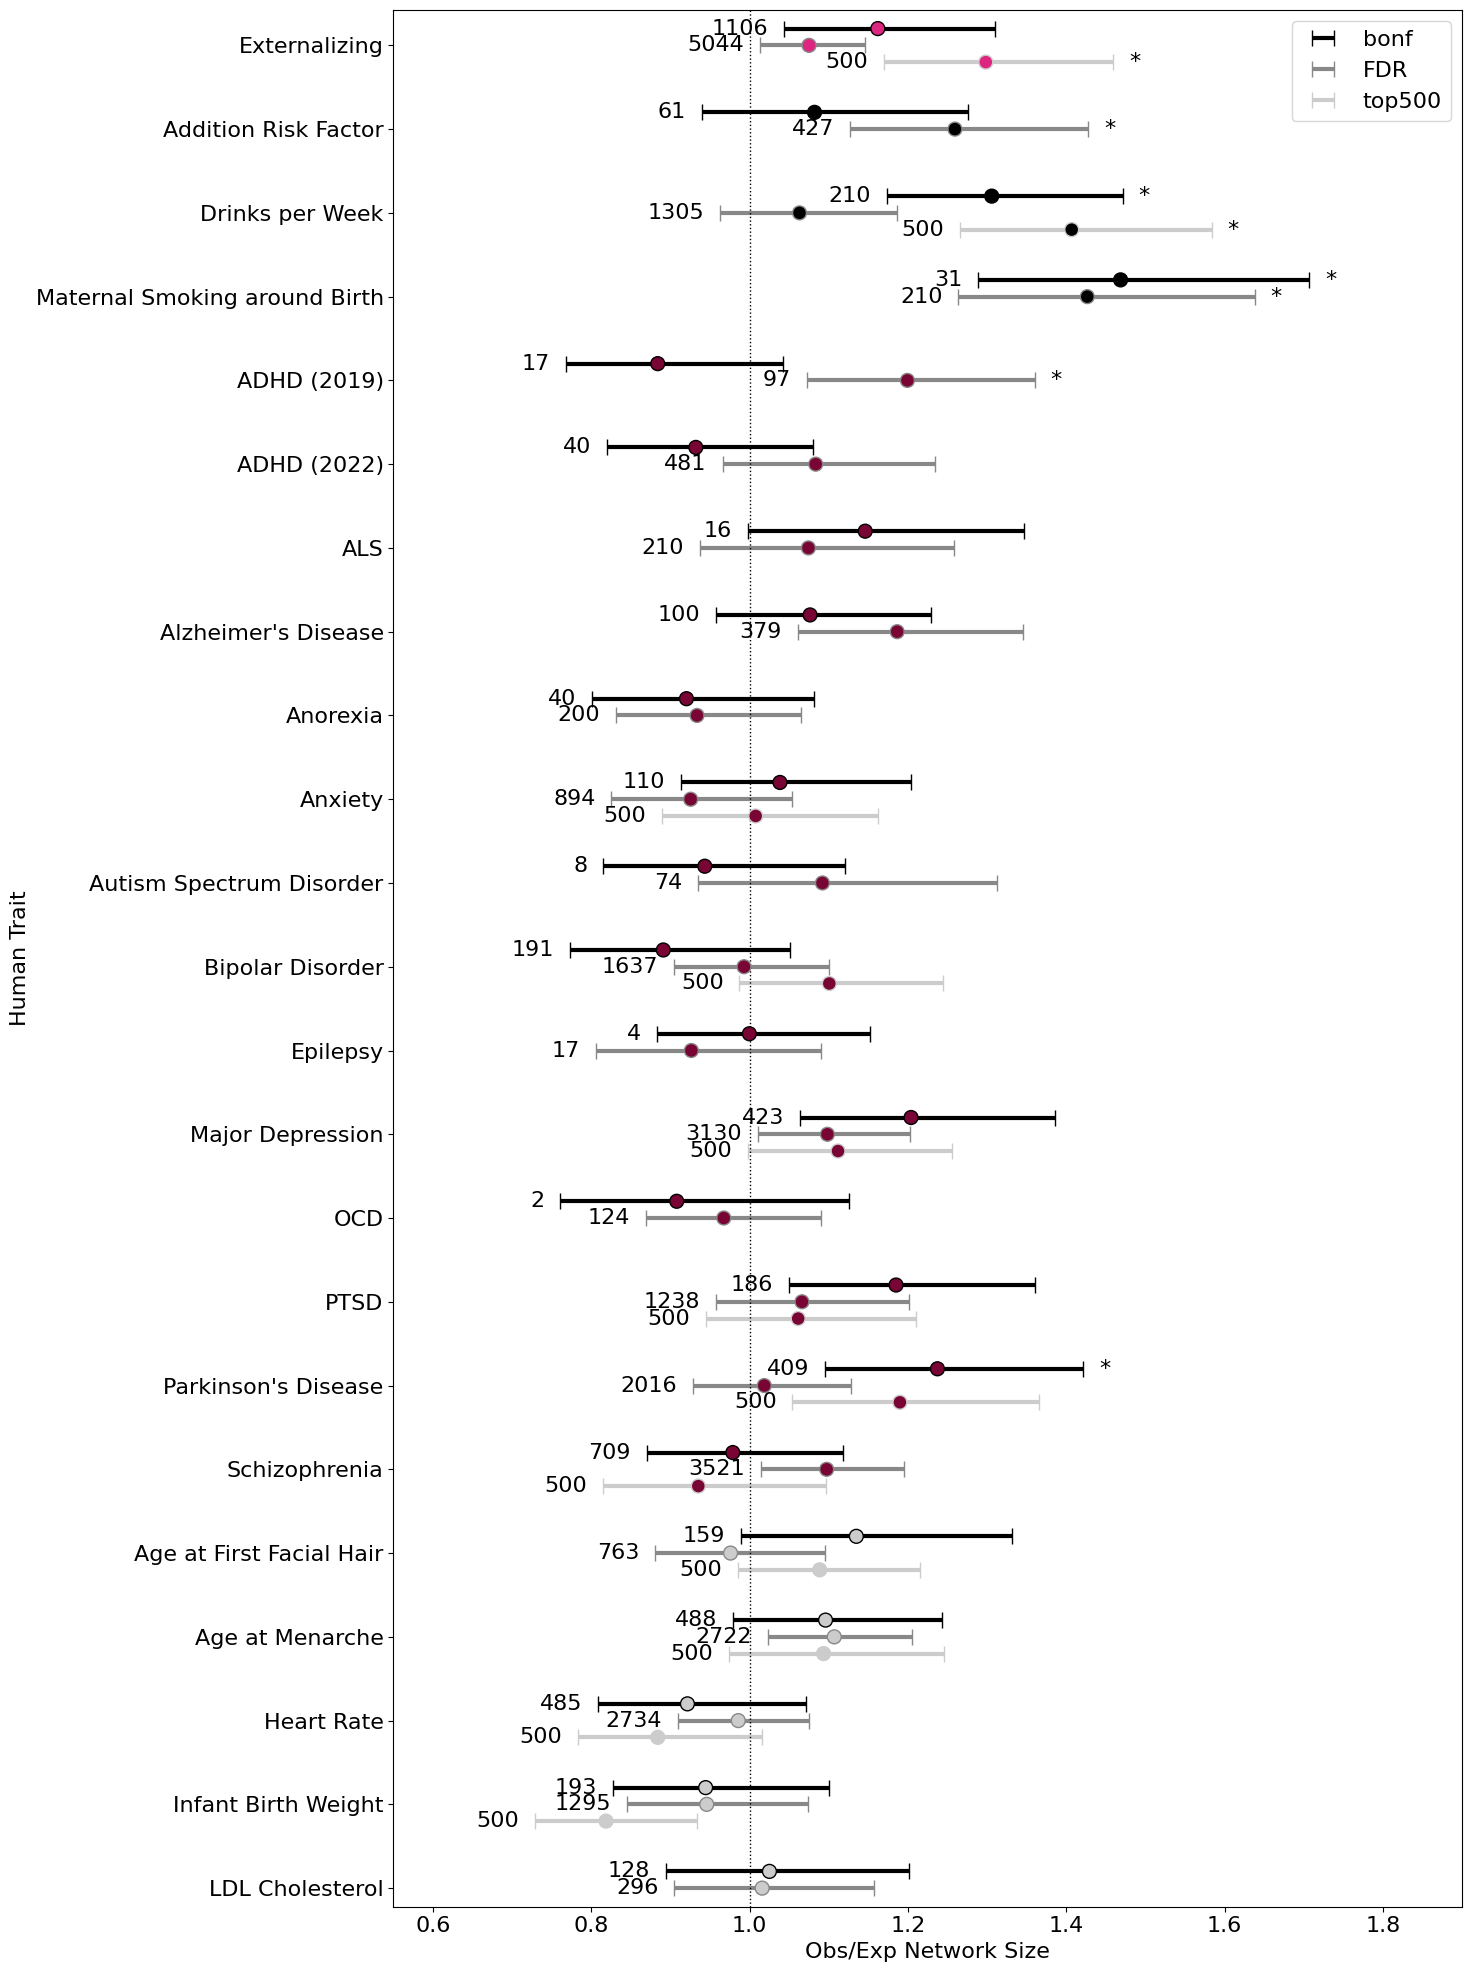

In [47]:
tbl_sub=tbl_sub.sort_values(['plt_order','Trait 2'],ascending=False)

traits = tbl_sub['Trait 2'].unique()
trait_to_y = {trait: i for i, trait in enumerate(traits)}
tbl_sub['y_numeric'] = tbl_sub['Trait 2'].map(trait_to_y)

#set offset
offsets = {
    'bonf': 0.2,
    'FDR': 0.0,
    'top500': -0.2,
    'ext_st22':0.0
}

# Colors for error bars
ecolors = {
    'bonf': '#000000',
    'FDR': '#888888',
    'top500': '#cccccc',
    'ext_st22': '#000000',

}

if ('loco_final_cf' in rat_data):
    fig=plt.figure(figsize=(15,20))
    plt.margins(0.01)

else:
    fig=plt.figure(figsize=(10,10))
    plt.margins(0.05)


plot_stars=True
plot_pvalues=False

for hcut, offset in offsets.items():
    filt = (tbl_sub['human_cutoff'] == hcut)
    x = tbl_sub.loc[filt, 'obs_exp']
    y = tbl_sub.loc[filt, 'y_numeric'] + offset
    lower = tbl_sub.loc[filt, 'lower_error']
    upper = tbl_sub.loc[filt, 'upper_error']
    colors = tbl_sub.loc[filt, 'colour']
    if hcut=='ext_st22':
        plt.errorbar(
            x=x,
            y=y,
            xerr=[lower, upper],
            fmt='o',
            markersize=0,
            ecolor=ecolors[hcut],
            capsize=3,
            label=None
        )
    else:
        plt.errorbar(
        x=x,
        y=y,
        xerr=[lower, upper],
        fmt='o',
        markersize=0,
        ecolor=ecolors[hcut],
        capsize=6,
        label=hcut,
        elinewidth=3
            
    )
    plt.scatter(
        x=x,
        y=y,
        c=colors,
        edgecolors=ecolors[hcut],
        zorder=3,
        s=100
    
    )
    if plot_stars:
        sigs = tbl_sub.loc[filt & tbl_sub['sig_overlap'], :]
        for xi, ui, yi in zip(sigs['obs_exp'], 
            sigs['upper_error'], 
            sigs['y_numeric'] + offset):
            plt.text(xi + ui + 0.02, yi, '*', va='center', ha='left', color='black')
    elif plot_pvalues:
        for xi, li, yi, label in zip(
            tbl_sub.loc[filt, 'obs_exp'],
            tbl_sub.loc[filt, 'upper_error'],
            tbl_sub.loc[filt, 'y_numeric'] + offset,
            tbl_sub.loc[filt, 'logp']):
            plt.text(xi + li + 0.1, yi, np.format_float_positional(label, precision=3),
                     va='center', ha='right', color='black')
    # Add n_seed labels to the left of the lower error bar
    for xi, li, yi, label in zip(
        tbl_sub.loc[filt, 'obs_exp'],
        tbl_sub.loc[filt, 'lower_error'],
        tbl_sub.loc[filt, 'y_numeric'] + offset,
        tbl_sub.loc[filt, 'n_seed']):
        plt.text(xi - li - 0.02, yi, int(label),
                 va='center', ha='right', color='black')

#plt.title(f'Network Overlap of {rat_data} with Human Traits')
plt.axvline(x=1, color='black', linestyle=':', linewidth=1)

# Replace y-axis with trait names
plt.xlim(0.55,1.9)
plt.yticks(list(trait_to_y.values()), list(trait_to_y.keys()))
plt.xlabel(f'Obs/Exp Network Size')
plt.ylabel('Human Trait')
plt.legend()
plt.tight_layout()
if save_fig:
    plt.savefig(f'figures/network_overlap_barplot_ctrls_{interactome_name}_{rat_data}_{cut_single}_{cut_comb}_pvalues-{plot_pvalues}.svg')

In [46]:
plt.rcParams.update({'font.size': 12})


In [47]:
save_fig=True

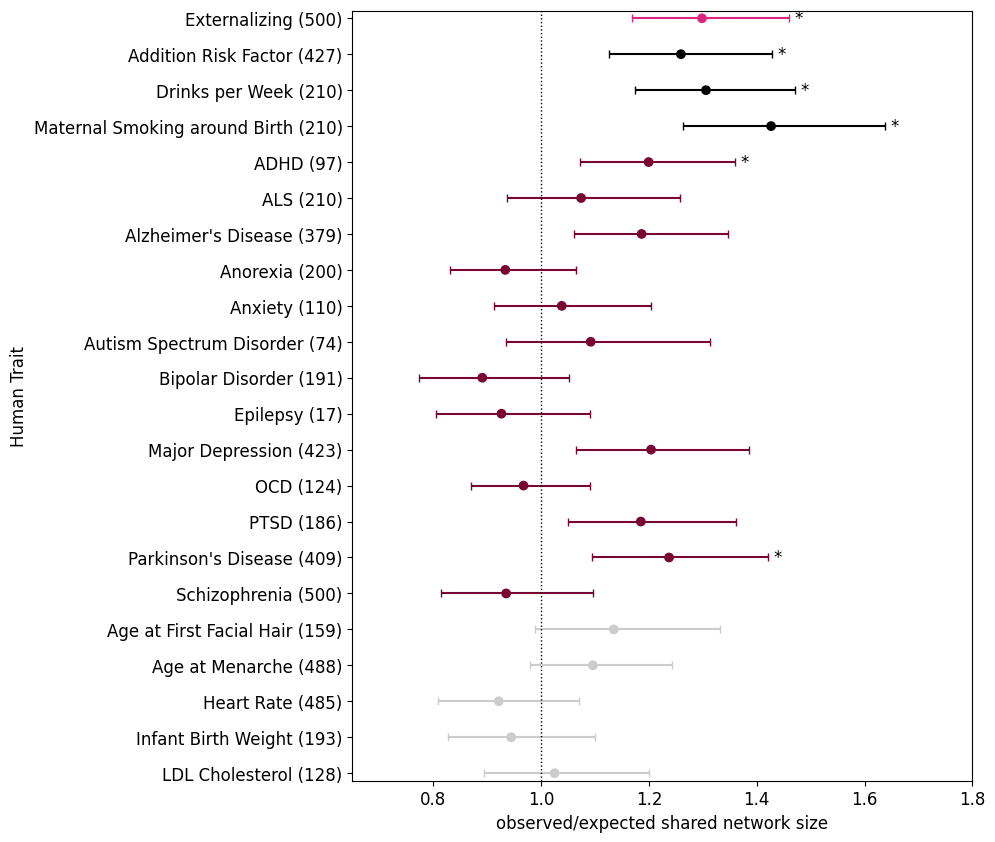

In [78]:
plt.rcParams.update({'font.size': 12})#set to 16 for slides
tbl_mini=tbl_sub[(tbl_sub['human_dataset'].isin(trait_cut))]
tbl_mini=tbl_mini[tbl_mini.label!='adhd2022']
tbl_mini=tbl_mini.replace('ADHD (2019)','ADHD')
#tbl_mini=tbl_mini.sort_values('ctrl_type',ascending=True).reset_index().drop('index',axis=1)

tbl_mini=tbl_mini.sort_values(['plt_order','Trait 2'],ascending=False)



if 'loco_final_cf' in rat_data:
    fig = plt.figure(figsize=(8, 10))
    plt.margins(0.01)

# Loop through each row to set individual colors for error bars and labels
for i, row in tbl_mini.iterrows():
    plt.errorbar(
        x=row.obs_exp,
        y=row['Trait 2'],
        xerr=[[row.lower_error], [row.upper_error]],
        fmt='o',
        markersize=0,
        ecolor=row.colour,       # Use colour for the error bar
        capsize=3
    )

# Scatter plot with color from tbl_mini.colour
plt.scatter(
    x=tbl_mini.obs_exp,
    y=tbl_mini['Trait 2'],
    c=tbl_mini.colour,
    edgecolors=tbl_mini.colour,  # Match edge color as well
    zorder=3
)

# Asterisk for significance
sigs = tbl_mini.loc[tbl_mini['sig_overlap'], :]
for xi, ui, yi in zip(
        sigs['obs_exp'],
        sigs['upper_error'] + 0.01,
        sigs['Trait 2']):
    plt.text(xi + ui, yi, '*', va='center', ha='left', color='black')


# Axis and labels
plt.axvline(x=1, color='black', linestyle=':', linewidth=1)
plt.xlabel('observed/expected shared network size')
plt.ylabel('Human Trait')

# Y-ticks with seed counts
plt.yticks(
    ticks=tbl_mini['Trait 2'],
    labels=tbl_mini['Trait 2'] + ' (' + tbl_mini.n_seed.astype(int).astype(str) + ')',
    color='black'  # Optional: change to 'none' if you want per-label coloring instead
)

plt.xlim(0.65, 1.8)
plt.savefig(f'figures/network_overlap_barplot_ctrls_{interactome_name}_{rat_data}_{cut_single}_{cut_comb}_primary_cutoff.svg')
plt.savefig(f'figures/network_overlap_barplot_ctrls_{interactome_name}_{rat_data}_{cut_single}_{cut_comb}_primary_cutoff.png',dpi=500,bbox_inches='tight')

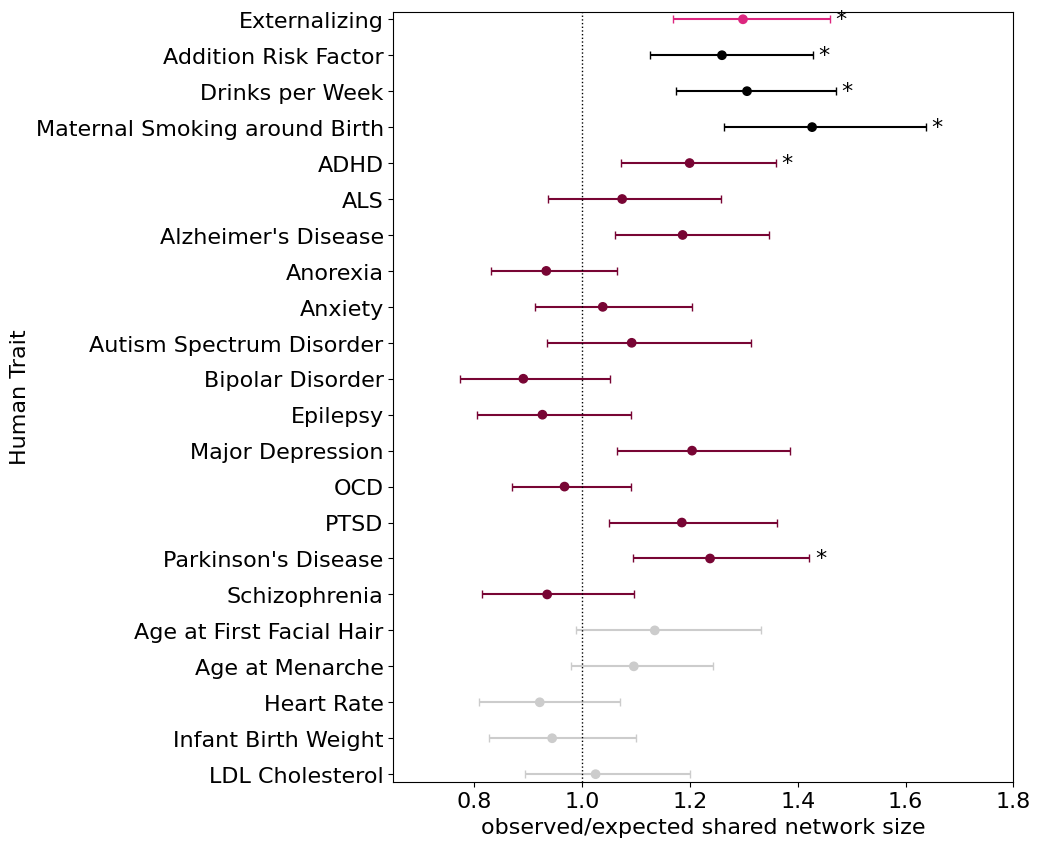

In [79]:
#version for talk

plt.rcParams.update({'font.size': 16})#set to 16 for slides
tbl_mini=tbl_sub[(tbl_sub['human_dataset'].isin(trait_cut))]
tbl_mini=tbl_mini[tbl_mini.label!='adhd2022']
tbl_mini=tbl_mini.replace('ADHD (2019)','ADHD')
#tbl_mini=tbl_mini.sort_values('ctrl_type',ascending=True).reset_index().drop('index',axis=1)

tbl_mini=tbl_mini.sort_values(['plt_order','Trait 2'],ascending=False)



if 'loco_final_cf' in rat_data:
    fig = plt.figure(figsize=(8, 10))
    plt.margins(0.01)

# Loop through each row to set individual colors for error bars and labels
for i, row in tbl_mini.iterrows():
    plt.errorbar(
        x=row.obs_exp,
        y=row['Trait 2'],
        xerr=[[row.lower_error], [row.upper_error]],
        fmt='o',
        markersize=0,
        ecolor=row.colour,       # Use colour for the error bar
        capsize=3
    )

# Scatter plot with color from tbl_mini.colour
plt.scatter(
    x=tbl_mini.obs_exp,
    y=tbl_mini['Trait 2'],
    c=tbl_mini.colour,
    edgecolors=tbl_mini.colour,  # Match edge color as well
    zorder=3
)

# Asterisk for significance
sigs = tbl_mini.loc[tbl_mini['sig_overlap'], :]
for xi, ui, yi in zip(
        sigs['obs_exp'],
        sigs['upper_error'] + 0.01,
        sigs['Trait 2']):
    plt.text(xi + ui, yi, '*', va='center', ha='left', color='black')


# Axis and labels
plt.axvline(x=1, color='black', linestyle=':', linewidth=1)
plt.xlabel('observed/expected shared network size')
plt.ylabel('Human Trait')

# Y-ticks with seed counts
plt.yticks(
    ticks=tbl_mini['Trait 2'],
    labels=tbl_mini['Trait 2'],
    color='black'  # Optional: change to 'none' if you want per-label coloring instead
)

plt.xlim(0.65, 1.8)
plt.savefig(f'figures/network_overlap_barplot_ctrls_{interactome_name}_{rat_data}_{cut_single}_{cut_comb}_primary_cutoff_slides.svg')
plt.savefig(f'figures/network_overlap_barplot_ctrls_{interactome_name}_{rat_data}_{cut_single}_{cut_comb}_primary_cutoff_slides.png',dpi=500,bbox_inches='tight')

# network overlap mini plots

In [48]:
save_fig=True

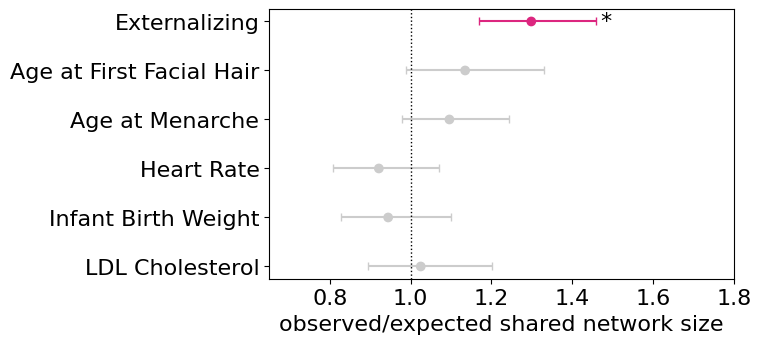

In [51]:
tbl_mini=tbl_sub[(tbl_sub['human_dataset'].isin(trait_cut))]
tbl_mini=tbl_mini[tbl_mini.label!='adhd2022']
tbl_mini=tbl_mini.replace('ADHD (2019)','ADHD')

tbl_mini=tbl_mini.sort_values(['ctrl_type'],ascending=True)
tbl_mini=tbl_mini.sort_values(['Trait 2'],ascending=False)



plt.rcParams.update({'font.size': 16})#set to 16 for slides

subgroup='negative'
if subgroup=='ext-comp':
    tbl_mini=tbl_mini[tbl_mini.ctrl_type.str.contains('ext')]
    tbl_mini=tbl_mini.sort_values('human_dataset',ascending=False).reset_index().drop('index',axis=1)
    tbl_mini=tbl_mini.sort_values('ctrl_type',ascending=True).reset_index().drop('index',axis=1)
else:
    tbl_mini=tbl_mini[(tbl_mini.ctrl_type==subgroup) | (tbl_mini.ctrl_type=='ext')]
tbl_mini=tbl_mini.sort_values(['ctrl_type'],ascending=False)


if subgroup=='ext':
    fig=plt.figure(figsize=(5,2.5))
    plt.margins(0.4)
elif subgroup=='psych':
    fig=plt.figure(figsize=(6,6))
    plt.margins(0.05)
elif subgroup=='negative':
    fig=plt.figure(figsize=(6,3.5))
    plt.margins(0.05)
elif subgroup=='SUD':
    fig=plt.figure(figsize=(6,3.5))

    tbl_mini=tbl_mini.sort_values(['ctrl_type'],ascending=True)

for i, row in tbl_mini.iterrows():
    plt.errorbar(
        x=row.obs_exp,
        y=row['Trait 2'],
        xerr=[[row.lower_error], [row.upper_error]],
        fmt='o',
        markersize=0,
        ecolor=row.colour,       # Use colour for the error bar
        capsize=3
    )

# Scatter plot with color from tbl_mini.colour
plt.scatter(
    x=tbl_mini.obs_exp,
    y=tbl_mini['Trait 2'],
    c=tbl_mini.colour,
    edgecolors=tbl_mini.colour,  # Match edge color as well
    zorder=3
)

# Asterisk for significance
sigs = tbl_mini.loc[tbl_mini['sig_overlap'], :]
for xi, ui, yi in zip(
        sigs['obs_exp'],
        sigs['upper_error'] + 0.01,
        sigs['Trait 2']):
    plt.text(xi + ui, yi, '*', va='center', ha='left', color='black')



'''for xi, ui, yi,label in zip(
    tbl_mini['obs_exp'], 
    tbl_mini['lower_error'], 
    tbl_mini['Trait 2'],
    tbl_mini['n_seed']):
    plt.text(xi - ui - 0.01, yi, int(label), va='center', ha='right', color='black')
'''
plt.axvline(x=1, color='black', linestyle=':', linewidth=1)
plt.xlabel('observed/expected shared network size')
plt.xlim(0.65, 1.8)

plt.savefig(f'figures/network_overlap_barplot_ctrls_{interactome_name}_{rat_data}_{cut_single}_{cut_comb}_mini_{subgroup}.svg')
plt.savefig(f'figures/network_overlap_barplot_ctrls_{interactome_name}_{rat_data}_{cut_single}_{cut_comb}_mini_{subgroup}.png',dpi=500,bbox_inches='tight')

# scatter plots network stats

In [115]:
plt.rcParams.update({'font.size': 16})

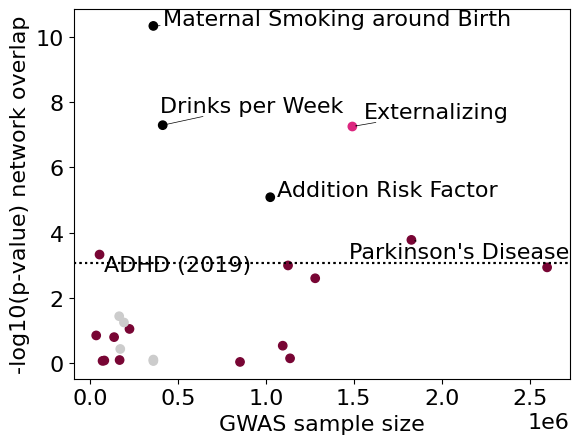

In [116]:
tbl_mini=tbl_sub[(tbl_sub['human_dataset'].isin(trait_cut))]
t=tbl_mini
sigcut=0.05/len(tbl_sub)
unique_traits = t.ctrl_type.unique()

plt.scatter(x=t['N trait 2'],y=t.logp,color=tbl_mini.colour,edgecolors=tbl_mini.colour)

plt.xlabel('GWAS sample size')
plt.ylabel('-log10(p-value) network overlap')
plt.axhline(-np.log10(sigcut),color='black',ls=':',label='bonferroni')
plt.axhline(-np.log10(0.05/len(tbl_sub)),color='black',ls=':',label='bonferroni')

texts = []
for i in t.index:
    if (t.empirical_p[i]<(sigcut)):
        texts.append(plt.annotate(t['Trait 2'][i], (t['N trait 2'][i], t.logp[i])))

# Adjust text to avoid overlap
adjust_text(texts, only_move={'points': 'xy', 'texts': 'xy'}, 
            arrowprops=dict(arrowstyle="->", color='black', lw=0.5))
if save_fig:
    plt.savefig(f'figures/sig_network_overlap_scatterplot_ctrls_{interactome_name}_{rat_data}_{cut_single}_{cut_comb}_mini_main_cut.svg')


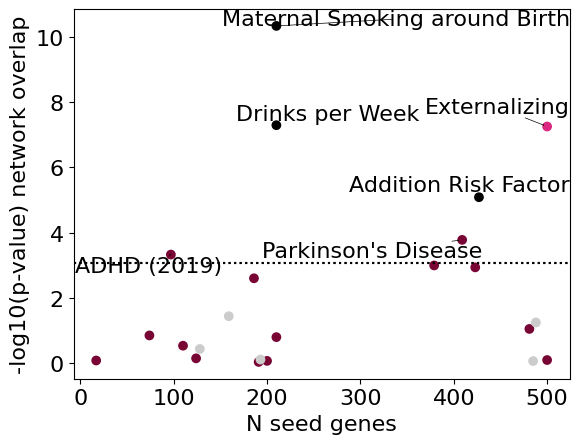

In [117]:
tbl_mini=tbl_sub[(tbl_sub['human_dataset'].isin(trait_cut))]
t=tbl_mini
sigcut=0.05/len(tbl_sub)
unique_traits = t.ctrl_type.unique()

plt.scatter(x=t['n_seed'],y=t.logp,color=tbl_mini.colour,edgecolors=tbl_mini.colour)

plt.xlabel('N seed genes')
plt.ylabel('-log10(p-value) network overlap')
plt.axhline(-np.log10(sigcut),color='black',ls=':',label='bonferroni')
plt.axhline(-np.log10(0.05/len(tbl_sub)),color='black',ls=':',label='bonferroni')

texts = []
for i in t.index:
    if (t.empirical_p[i]<(sigcut)):
        texts.append(plt.annotate(t['Trait 2'][i], (t['n_seed'][i], t.logp[i])))

# Adjust text to avoid overlap
adjust_text(texts, only_move={'points': 'xy', 'texts': 'xy'}, 
            arrowprops=dict(arrowstyle="->", color='black', lw=0.5))
if save_fig:
    plt.savefig(f'figures/sig_network_overlap_nseed_scatterplot_ctrls_{interactome_name}_{rat_data}_{cut_single}_{cut_comb}_mini_main_cut.svg')


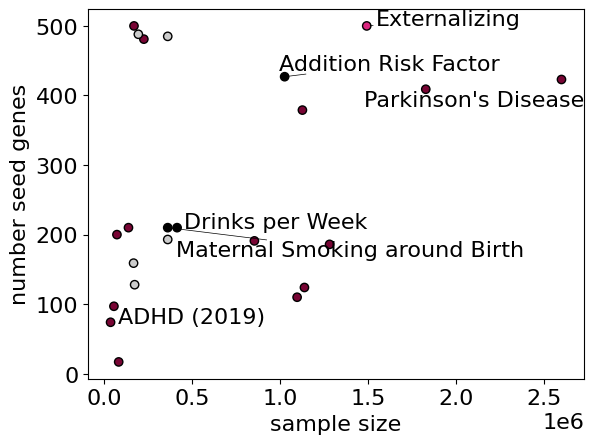

In [118]:
t=tbl_mini
sigcut=0.05/len(tbl_sub)
unique_traits = t.ctrl_type.unique()

plt.scatter(y=t['n_seed'],x=t['N trait 2'],color=tbl_mini.colour,edgecolors='black')

plt.ylabel('number seed genes')
plt.xlabel('sample size')

texts = []
for i in t.index:
    if (t.empirical_p[i]<(sigcut)):
        texts.append(plt.annotate(t['Trait 2'][i], (t['N trait 2'][i], t.n_seed[i])))

# Adjust text to avoid overlap
adjust_text(texts, only_move={'points': 'xy', 'texts': 'xy'}, 
            arrowprops=dict(arrowstyle="->", color='black', lw=0.5))

#plt.savefig(f'figures/sig_network_overlap_scatterplot_ctrls_{interactome_name}_{rat_data}_{cut_single}_{cut_comb}_mini_main_cut.svg')


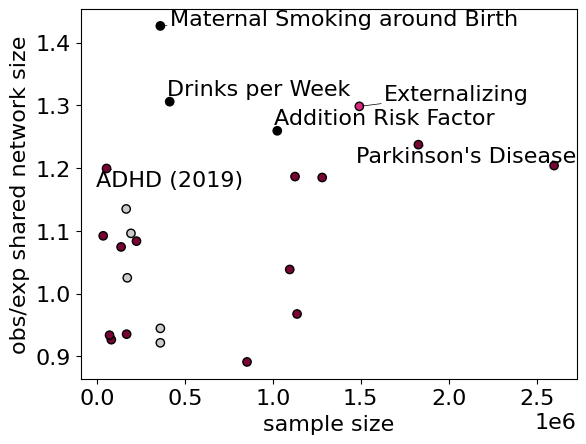

In [120]:
t=tbl_mini
sigcut=0.05/len(tbl_sub)
unique_traits = t.ctrl_type.unique()

plt.scatter(x=t['N trait 2'],y=t.obs_exp,color=tbl_mini.colour,edgecolors='black')

plt.xlabel('sample size')
plt.ylabel('obs/exp shared network size')
#plt.axhline(-np.log10(sigcut),color='black',ls=':',label='bonferroni')
texts = []
for i in t.index:
    if (t.empirical_p[i]<(sigcut)):
        texts.append(plt.annotate(t['Trait 2'][i], (t['N trait 2'][i], t.obs_exp[i])))

# Adjust text to avoid overlap
adjust_text(texts, only_move={'points': 'xy', 'texts': 'xy'}, 
            arrowprops=dict(arrowstyle="->", color='black', lw=0.5))
if save_fig:
    plt.savefig(f'figures/network_overlap_scatterplot_ctrls_{interactome_name}_{rat_data}_{cut_single}_{cut_comb}_mini_main_cut.svg')


# UMAP

In [67]:
import umap

In [152]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

In [94]:
sig_traits=['park_bonf',
 'adhd_FDR',
 'ext_top500',
 'maternal_smok_FDR',
 'dpw_bonf',
 'addict-rf_FDR']
#sig_traits=['Addition Risk Factor','Drinks per Week','ADHD',"Parkinson's Disease",'Externalizing','Maternal Smoking around Birth',]

In [100]:
tbl_mini=tbl_sub[(tbl_sub['human_dataset'].isin(trait_cut))]
tbl_mini=tbl_mini[tbl_mini.label!='adhd2022']
tbl_mini=tbl_mini.replace('ADHD (2019)','ADHD')

tbl_mini=tbl_mini.sort_values(['ctrl_type'],ascending=True)
tbl_mini=tbl_mini.sort_values(['Trait 2'],ascending=False)

trait_list=list(set(tbl_mini.human_dataset))
#trait_list=[x+'_'+interactome_name for x in trait_list]

In [101]:
trait_list

['asd_FDR',
 'ocd_FDR',
 'anorexia_FDR',
 'park_bonf',
 'maternal_smok_FDR',
 'epilepsy_FDR',
 'bipolar_bonf',
 'LDL_bonf',
 'addict-rf_FDR',
 'facial_hair_bonf',
 'dep_bonf',
 'ptsd_bonf',
 'ext_top500',
 'age_menarche_bonf',
 'adhd_FDR',
 'dpw_bonf',
 'infant_bw_bonf',
 'alz_FDR',
 'als_FDR',
 'hr_bonf',
 'anxiety_bonf',
 'scz_top500']

In [102]:
combined_nps={}
single_nps={}
for x in trait_list:
    y=combine_nps_table(NPS_dict[f'{rat_data}_{interactome_name}'],NPS_dict[f'{x}_{interactome_name}'])
    combined_nps[x]=set(y[(y.NPSr>cut_single)&(y.NPSc>cut_single)&(y.NPScr>cut_comb)].index)
    single_nps[x]=set(y[y.NPSc>cut_single].index)

In [309]:
plt.rcParams.update({'font.size': 16})

## UMAP seed genes

In [69]:
y=tbl_mini[['human_dataset','Trait 2','ctrl_type','colour']].reset_index()
y=y.drop('index', axis=1)
y.loc[len(y)+1]=['loco_final_cf_FDR', 'Locomotor','Locomotor','white']
y=y.replace('psych','Neuropsychiatric').replace('negative','Physiological').replace('ext','Externalizing')

In [70]:
subset_seeds = {key: seed_dict[key] for key in trait_list+['loco_final_cf_FDR'] if key in seed_dict}

In [71]:
subset=False

In [72]:
gene_groups=subset_seeds
if subset:
    gene_groups = {key: gene_groups[key] for key in sig_traits if key in gene_groups}

# Collect union of all genes
all_genes = sorted(set().union(*gene_groups.values()))

# Create binary matrix
data = []
labels = []
for group_name, genes in gene_groups.items():
    vector = [1 if g in genes else 0 for g in all_genes]
    data.append(vector)
    labels.append(group_name)

df = pd.DataFrame(data, index=labels, columns=all_genes)

# Run UMAP
reducer = umap.UMAP(random_state=42, n_neighbors=2, min_dist=0.1)
embedding = reducer.fit_transform(df.values)

# Merge embedding with metadata
df_emb = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"], index=labels)
df_emb = df_emb.merge(y, left_index=True, right_on="human_dataset")


/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [74]:
embedding

array([[-6.1105065, 11.989379 ],
       [-5.4116325, 11.973886 ],
       [-6.7286925, 14.2438   ],
       [-5.5022964, 12.672574 ],
       [-6.1663184, 14.537401 ],
       [-6.844979 , 14.990856 ],
       [-7.2100954, 12.999424 ]], dtype=float32)

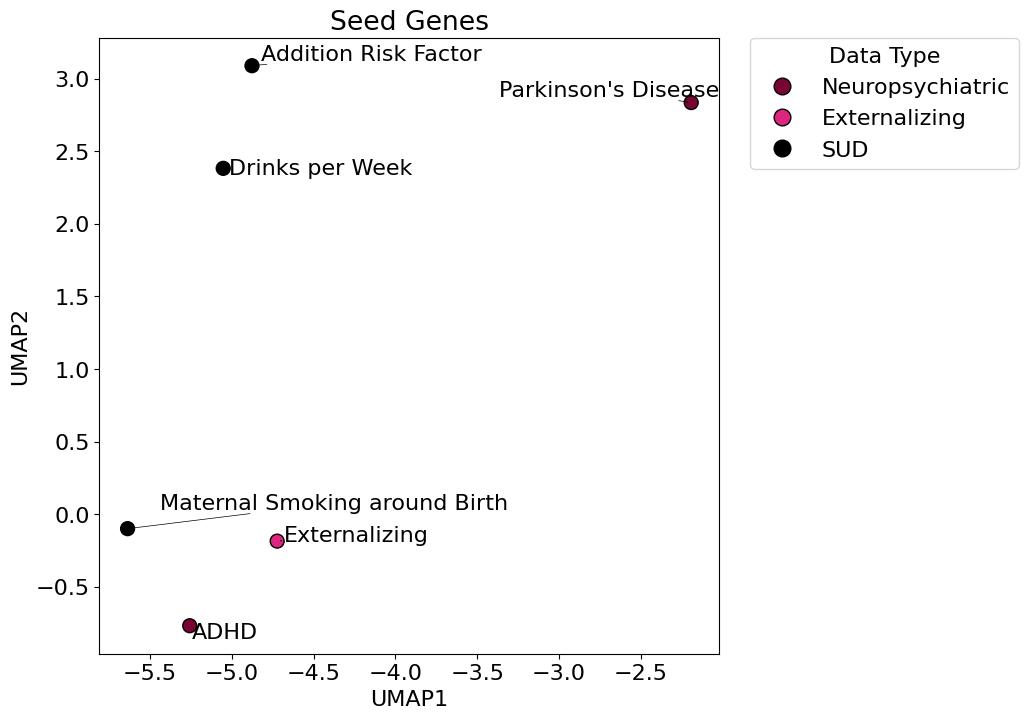

In [258]:
plt.figure(figsize=(8,8))
plt.scatter(df_emb["UMAP1"], df_emb["UMAP2"], 
            c=df_emb["colour"], s=100, edgecolor="k")

# Collect texts for adjustment
texts = []
for i, row in df_emb.iterrows():
    texts.append(plt.text(row["UMAP1"], row["UMAP2"], row["Trait 2"], fontsize=16))

# Adjust label positions to avoid overlap
adjust_text(texts, only_move={'points': 'xy', 'texts': 'xy'}, 
            arrowprops=dict(arrowstyle="->", color='black', lw=0.5))

#Add legend
legend_elements = []
for ctrl in df_emb["ctrl_type"].unique():
    color = df_emb[df_emb["ctrl_type"] == ctrl]["colour"].iloc[0]
    legend_elements.append(
        Line2D([0], [0], marker='o', color='w', label=ctrl,
               markerfacecolor=color, markeredgecolor="black", markersize=12)
    )


plt.legend(handles=legend_elements, title="Data Type",bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title("Seed Genes")

if save_fig:
    if subset:
        subset_label='_subset'
    else:
        subset_label=''
    plt.savefig(f'figures/UMAP_seed_genes_nps_loco_final_cf{subset_label}.svg')
    plt.savefig(f'figures/UMAP_seed_genes_nps_loco_final_cf{subset_label}.png',dpi=500,bbox_inches='tight')
plt.show()


## UMAP colocalized network genes

In [293]:
subset=False

In [302]:
gene_groups=combined_nps
if subset:
    gene_groups = {key: gene_groups[key] for key in sig_traits if key in gene_groups}
# Collect union of all genes
all_genes = sorted(set().union(*gene_groups.values()))

# Create binary matrix
data = []
labels = []
for group_name, genes in gene_groups.items():
    vector = [1 if g in genes else 0 for g in all_genes]
    data.append(vector)
    labels.append(group_name)

df = pd.DataFrame(data, index=labels, columns=all_genes)

# Run UMAP
reducer = umap.UMAP(random_state=42, n_neighbors=2, min_dist=0.1)
embedding = reducer.fit_transform(df.values)

# Merge embedding with metadata
df_emb = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"], index=labels)
df_emb = df_emb.merge(y, left_index=True, right_on="human_dataset")


/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


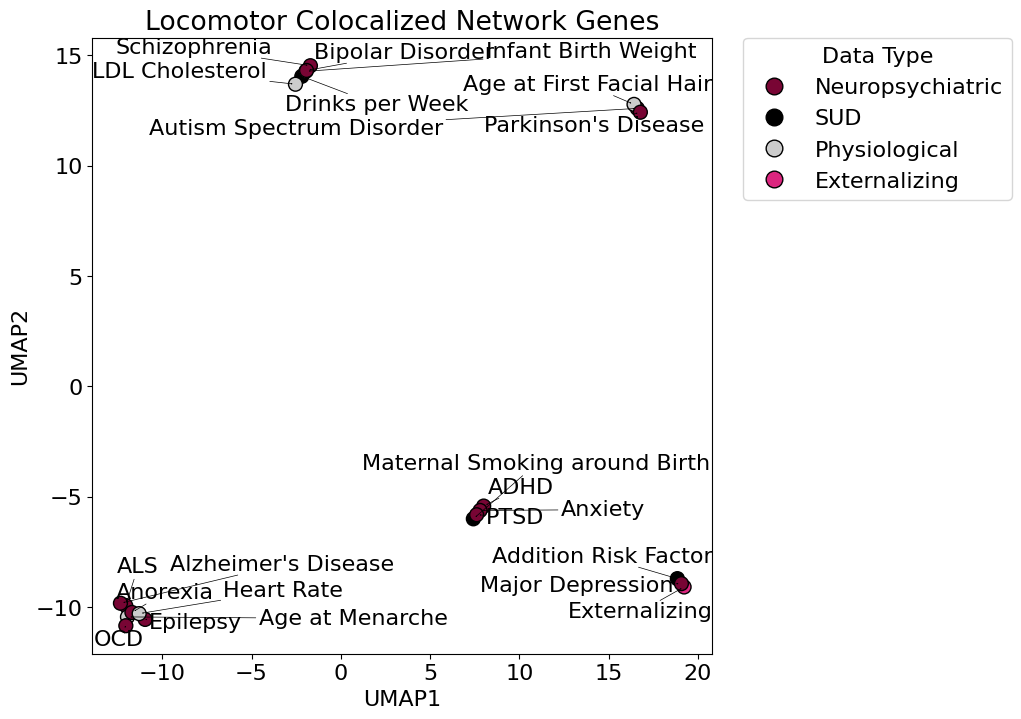

In [310]:
plt.figure(figsize=(8,8))
plt.scatter(df_emb["UMAP1"], df_emb["UMAP2"], 
            c=df_emb["colour"], s=100, edgecolor="k")

# Collect texts for adjustment
texts = []
for i, row in df_emb.iterrows():
    texts.append(plt.text(row["UMAP1"], row["UMAP2"], row["Trait 2"]))

# Adjust label positions to avoid overlap
adjust_text(texts, only_move={'points': 'xy', 'texts': 'xy'}, 
            arrowprops=dict(arrowstyle="->", color='black', lw=0.5))

#Add legend
#Add legend
legend_elements = []
for ctrl in df_emb["ctrl_type"].unique():
    color = df_emb[df_emb["ctrl_type"] == ctrl]["colour"].iloc[0]
    legend_elements.append(
        Line2D([0], [0], marker='o', color='w', label=ctrl,
               markerfacecolor=color, markeredgecolor="black", markersize=12)
    )


plt.legend(handles=legend_elements, title="Data Type",bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title("Locomotor Colocalized Network Genes")
if save_fig:
    if subset:
        subset_label='_subset'
    else:
        subset_label=''
    plt.savefig(f'figures/UMAP_combined_nps_loco_final_cf{subset_label}.svg')
    plt.savefig(f'figures/UMAP_combined_nps_loco_final_cf{subset_label}.png',dpi=500,bbox_inches='tight')

plt.show()


## UMAP single network propagation

In [263]:
subset=True

In [266]:
gene_groups=single_nps
if subset:
    gene_groups = {key: gene_groups[key] for key in sig_traits if key in gene_groups}

# Collect union of all genes
all_genes = sorted(set().union(*gene_groups.values()))

# Create binary matrix
data = []
labels = []
for group_name, genes in gene_groups.items():
    vector = [1 if g in genes else 0 for g in all_genes]
    data.append(vector)
    labels.append(group_name)

df = pd.DataFrame(data, index=labels, columns=all_genes)

# Run UMAP
reducer = umap.UMAP(random_state=42, n_neighbors=2, min_dist=0.1)
embedding = reducer.fit_transform(df.values)

# Merge embedding with metadata
df_emb = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"], index=labels)
df_emb = df_emb.merge(y, left_index=True, right_on="human_dataset")


/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


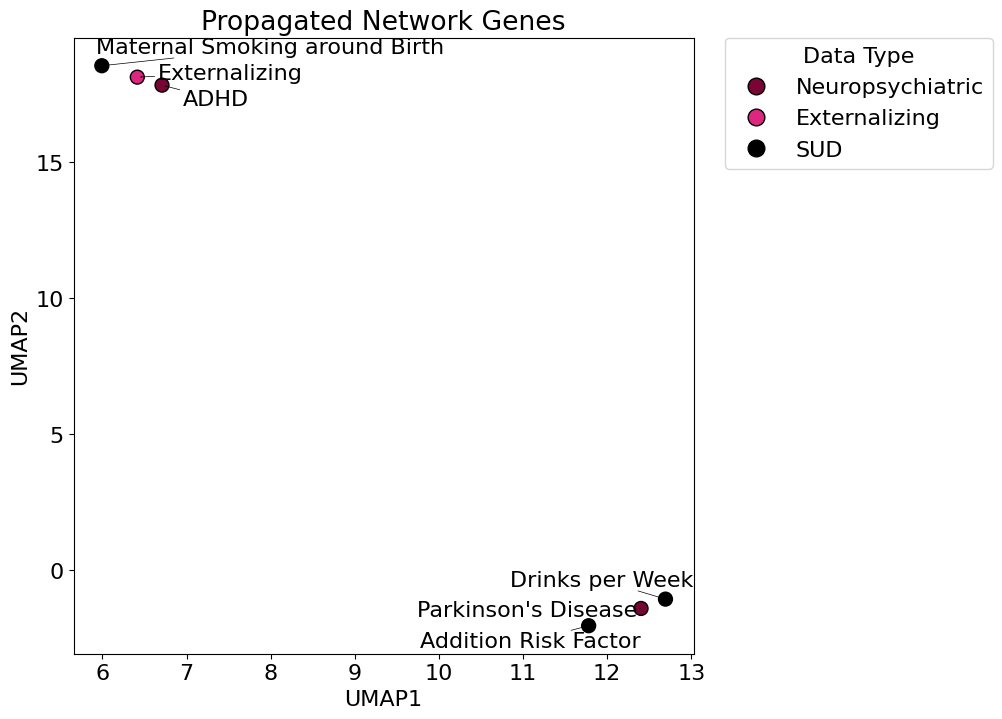

In [267]:
plt.figure(figsize=(8,8))
plt.scatter(df_emb["UMAP1"], df_emb["UMAP2"], 
            c=df_emb["colour"], s=100, edgecolor="k")

# Collect texts for adjustment
texts = []
for i, row in df_emb.iterrows():
    texts.append(plt.text(row["UMAP1"], row["UMAP2"], row["Trait 2"], fontsize=16))

# Adjust label positions to avoid overlap
adjust_text(texts, only_move={'points': 'xy', 'texts': 'xy'}, 
            arrowprops=dict(arrowstyle="->", color='black', lw=0.5))


#Add legend
legend_elements = []
for ctrl in df_emb["ctrl_type"].unique():
    color = df_emb[df_emb["ctrl_type"] == ctrl]["colour"].iloc[0]
    legend_elements.append(
        Line2D([0], [0], marker='o', color='w', label=ctrl,
               markerfacecolor=color, markeredgecolor="black", markersize=12)
    )


plt.legend(handles=legend_elements, title="Data Type",bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title("Propagated Network Genes")
if save_fig:
    if subset:
        subset_label='_subset'
    else:
        subset_label=''
    plt.savefig(f'figures/UMAP_single_prop_nps_loco_final_cf{subset_label}.svg')
    plt.savefig(f'figures/UMAP_single_prop_nps_loco_final_cf{subset_label}.png',dpi=500,bbox_inches='tight')
plt.show()


# seed gene overlap table

In [104]:
def seed_overlap(tblr_seed,tblc_seed,all_nodes):
    tblr_seed=list(set(tblr_seed).intersection(all_nodes))
    tblc_seed=list(set(tblc_seed).intersection(all_nodes))  
    #define overlap for seed genes plot
    seed_overlap=set(tblr_seed).intersection(set(tblc_seed))
    #print(seed_overlap)
    #compute significance of seed genes overlap- same test as used in BMI paper
    hyper = hypergeom(M=len(all_nodes), n=len(tblr_seed), N=len(tblc_seed))
    p_intersect_seed = hyper.sf(len(seed_overlap))
    return([len(tblr_seed),len(tblc_seed),len(seed_overlap),p_intersect_seed])


In [105]:
trait_list=list(set(tbl_mini.human_dataset))

In [106]:
y=tbl_mini[['human_dataset','Trait 2','ctrl_type','colour']].reset_index()
y=y.drop('index', axis=1)
y.loc[len(y)+1]=['loco_final_cf_FDR', 'Locomotor','Locomotor','white']
y=y.replace('psych','Neuropsychiatric').replace('negative','Physiological').replace('ext','Externalizing')

In [112]:
seed_overlap_dict={}
for x in trait_list:
    print(x)
    seed_overlap_dict[x]=seed_overlap(seed_dict[rat_data],seed_dict[x],all_nodes)

epilepsy_FDR
bipolar_bonf
infant_bw_bonf
ext_top500
scz_top500
als_FDR
facial_hair_bonf
maternal_smok_FDR
asd_FDR
anorexia_FDR
anxiety_bonf
ptsd_bonf
addict-rf_FDR
dep_bonf
dpw_bonf
LDL_bonf
alz_FDR
ocd_FDR
adhd_FDR
hr_bonf
park_bonf
age_menarche_bonf


In [113]:
seed_overlap_tbl=pd.DataFrame.from_dict(seed_overlap_dict,orient='index')
seed_overlap_tbl=seed_overlap_tbl.merge(y[['human_dataset','Trait 2','ctrl_type']], left_index=True,right_on='human_dataset',how='outer')
seed_overlap_tbl.index=seed_overlap_tbl['Trait 2']
seed_overlap_tbl=seed_overlap_tbl.drop(['human_dataset','Trait 2'],axis=1)
seed_overlap_tbl.columns=['Rat Locomotor Seeds (N)','Human Seeds (N)','Overlapping Seeds (N)','Sig. Overlap (p-value)','Data Type']
seed_overlap_tbl=seed_overlap_tbl.drop('Locomotor',axis=0)
seed_overlap_tbl[['Rat Locomotor Seeds (N)','Human Seeds (N)','Overlapping Seeds (N)']]=seed_overlap_tbl[['Rat Locomotor Seeds (N)','Human Seeds (N)','Overlapping Seeds (N)']].astype(int)
seed_overlap_tbl['Sig. Overlap (p-value)']=np.round(seed_overlap_tbl['Sig. Overlap (p-value)'],2)
seed_overlap_tbl=seed_overlap_tbl.sort_values(['Data Type','Trait 2'])

In [114]:
seed_overlap_tbl

,Rat Locomotor Seeds (N),Human Seeds (N),Overlapping Seeds (N),Sig. Overlap (p-value),Data Type
Trait 2,,,,,
Externalizing,336,500,8,0.51,Externalizing
ADHD,336,83,2,0.18,Neuropsychiatric
ALS,336,193,0,0.97,Neuropsychiatric
Alzheimer's Disease,336,348,10,0.04,Neuropsychiatric
Anorexia,336,181,2,0.61,Neuropsychiatric
Anxiety,336,100,0,0.83,Neuropsychiatric
Autism Spectrum Disorder,336,65,0,0.68,Neuropsychiatric
Bipolar Disorder,336,154,1,0.75,Neuropsychiatric
Epilepsy,336,17,0,0.26,Neuropsychiatric


In [110]:
seed_overlap_tbl.to_csv('seed_overlap_locomotor_final_cf.csv')

# plot upset plot of network genes

In [104]:
subset=True
gene_groups=combined_nps
if subset:
    gene_groups = {key: gene_groups[key] for key in sig_traits if key in gene_groups}


In [54]:
#export table of all NPS scores for signifcant networks
'''r=(NPS_dict[f'{rat_data}_{interactome_name}'])
r.columns=['NPS_loco_FDR']
for d in tbl_mini.human_dataset:
    c=list(r.columns)
    r=r.merge(NPS_dict[f'{d}_{interactome_name}'],left_index=True,right_index=True)
    r.columns=c+[f'NPS_{d}']
r.to_csv('NPS_all_significant_networks.csv')'''

"r=(NPS_dict[f'{rat_data}_{interactome_name}'])\nr.columns=['NPS_loco_FDR']\nfor d in tbl_mini.human_dataset:\n    c=list(r.columns)\n    r=r.merge(NPS_dict[f'{d}_{interactome_name}'],left_index=True,right_index=True)\n    r.columns=c+[f'NPS_{d}']\nr.to_csv('NPS_all_significant_networks.csv')"

In [55]:
#export table of genes in colocalized networks
'''r=pd.DataFrame(all_nodes)
for x in gene_groups.keys():
    r[x]=r[0].apply(lambda y: y in gene_groups[x])
r.to_csv('network_genes_all_significant_networks.csv',index=False)'''

"r=pd.DataFrame(all_nodes)\nfor x in netgene_dict.keys():\n    r[x]=r[0].apply(lambda y: y in netgene_dict[x])\nr.to_csv('network_genes_all_significant_networks.csv',index=False)"

In [105]:
overlap=from_contents(gene_groups)

In [106]:
unique={
    'park_bonf':145,
    'adhd_FDR':85, 
    'ext_top500':60, 
    'maternal_smok_FDR':89, 
    'dpw_bonf':72, 
    'addict-rf_FDR':68}

In [143]:
label_dict=dict(zip(tbl_mini['human_dataset'],tbl_mini['Trait 2']))

In [145]:
for d in sorted(unique.keys()):
    print(f'{label_dict[d]}: {str(round(100*unique[d]/len(gene_groups[d])))}% ({str(len(gene_groups[d]))})')

Addition Risk Factor: 28% (246)
ADHD: 41% (207)
Drinks per Week: 33% (220)
Externalizing: 23% (263)
Maternal Smoking around Birth: 36% (248)
Parkinson's Disease: 61% (239)


In [147]:
gene_groups.keys()

dict_keys(['park_bonf', 'adhd_FDR', 'ext_top500', 'maternal_smok_FDR', 'dpw_bonf', 'addict-rf_FDR'])

In [ ]:
gene_groups['adhd_FDR'].intersection()

In [149]:
park_unique=set(gene_groups['park_bonf']).difference(list(gene_groups['adhd_FDR'])+list(gene_groups[ 'ext_top500'])+list(gene_groups[ 'maternal_smok_FDR'])+list(gene_groups[ 'dpw_bonf'])+list(gene_groups[ 'addict-rf_FDR']))

In [151]:
len(park_unique)

127

In [154]:
shared=(gene_groups['adhd_FDR']).intersection(gene_groups[ 'ext_top500']).intersection(gene_groups[ 'maternal_smok_FDR']).intersection(gene_groups[ 'dpw_bonf']).intersection(gene_groups[ 'addict-rf_FDR']).intersection(gene_groups[ 'park_bonf'])




In [155]:
shared

{'GLRA1', 'GRIA1', 'PTPRN'}

In [112]:
for d in tbl_mini.human_dataset:
    for e in tbl_mini.human_dataset:
        print(f'{d} - {e}: {str(len(set(gene_groups[d]).intersection(gene_groups[e])))}')

KeyError: 'scz_top500'

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

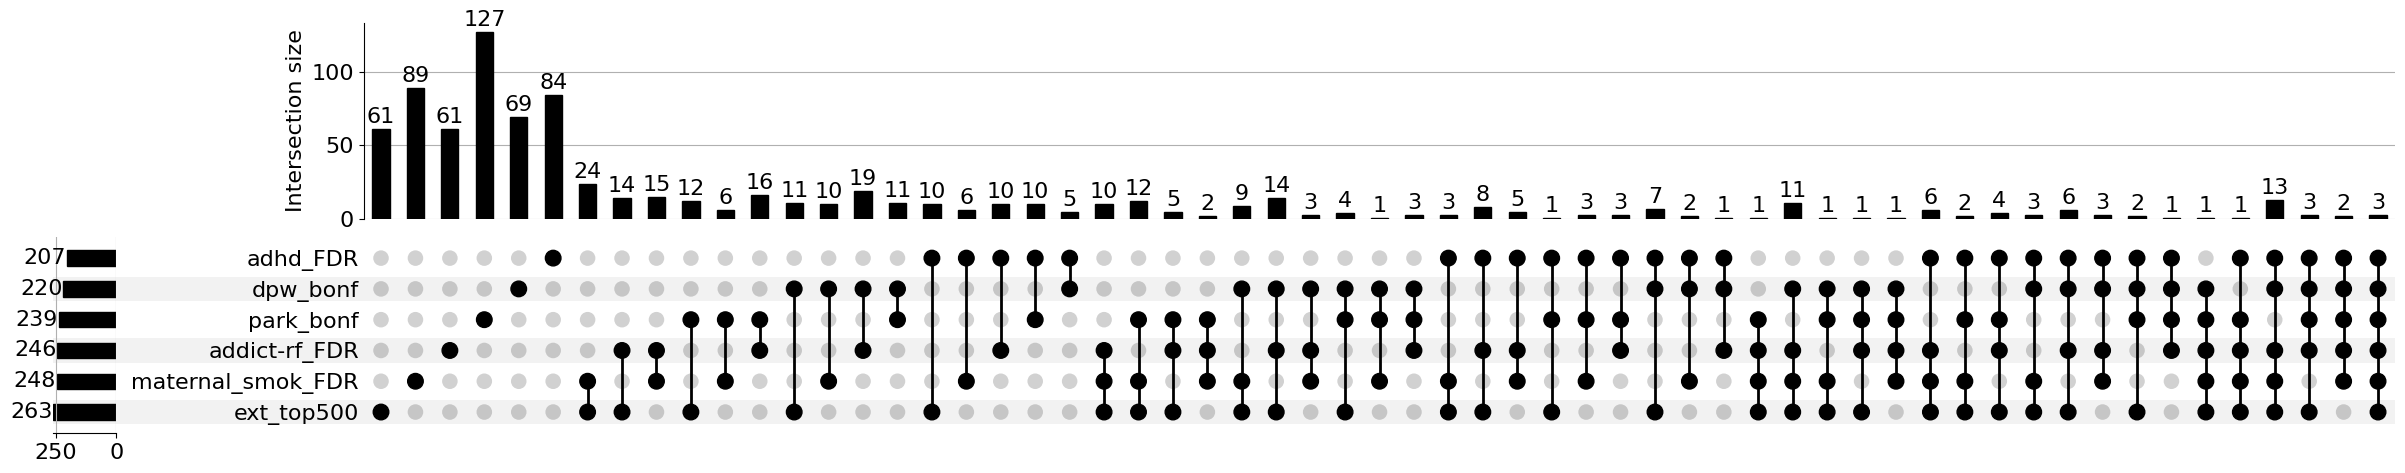

In [156]:
UpSet(overlap, sort_by='degree',subset_size='count', show_counts=True).plot()

# heatmap

In [63]:
t = tbl_sub.pivot(index='human_dataset', columns='rat_dataset', values='obs_exp')
distance = t.applymap(lambda x: (x - 1))
annot_data = tbl_sub.pivot(index='human_dataset', columns='rat_dataset', values='empirical_p')
annot = annot_data.applymap(lambda p: '*' if p < 0.05/len(tbl_sub) else '')


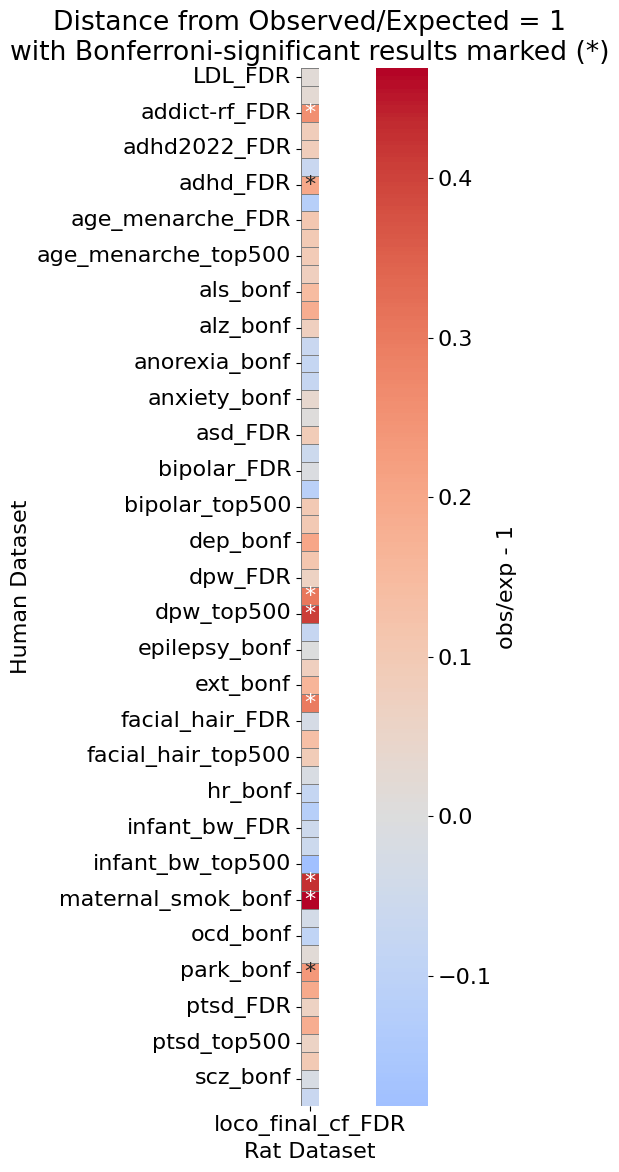

In [64]:
plt.figure(figsize=(12,12))
sns.heatmap(distance, annot=annot, fmt='', cmap='coolwarm', center=0,
            cbar_kws={'label': 'obs/exp - 1'}, linewidths=0.5, linecolor='gray',square=True)

plt.title('Distance from Observed/Expected = 1\nwith Bonferroni-significant results marked (*)')
plt.ylabel('Human Dataset')
plt.xlabel('Rat Dataset')
plt.tight_layout()
plt.show()